In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
! pip install -q --upgrade pip
! pip install -q matplotlib
!pip install -q torchsummary

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


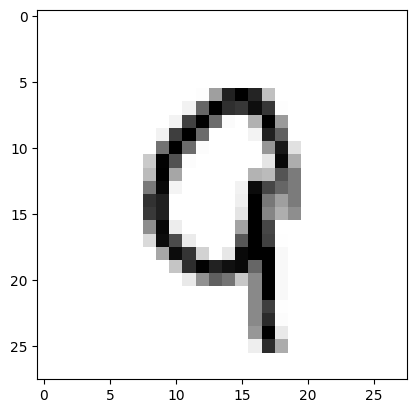

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

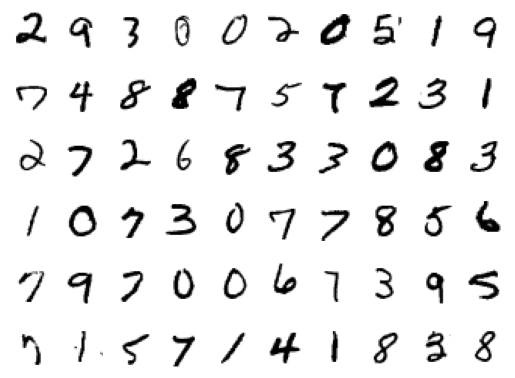

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [10]:
from src.models import models

In [11]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = models.NetWithGAP().to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1, 10,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:
model =  models.NetWithGAP().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.41411736607551575 Batch_id=468 Accuracy=78.95: 100%|██████████| 469/469 [00:04<00:00, 108.90it/s]



Test set: Average loss: 0.4793, Accuracy: 9116/10000 (91.16%)

EPOCH: 1


Loss=0.18930785357952118 Batch_id=468 Accuracy=95.59: 100%|██████████| 469/469 [00:04<00:00, 106.38it/s]



Test set: Average loss: 0.2801, Accuracy: 9445/10000 (94.45%)

EPOCH: 2


Loss=0.20968838036060333 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:04<00:00, 108.36it/s]



Test set: Average loss: 0.1617, Accuracy: 9698/10000 (96.98%)

EPOCH: 3


Loss=0.14606676995754242 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:04<00:00, 107.22it/s]



Test set: Average loss: 0.1745, Accuracy: 9623/10000 (96.23%)

EPOCH: 4


Loss=0.08224254101514816 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:04<00:00, 109.76it/s] 



Test set: Average loss: 0.1520, Accuracy: 9632/10000 (96.32%)

EPOCH: 5


Loss=0.0864112600684166 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:04<00:00, 107.06it/s]  



Test set: Average loss: 0.1317, Accuracy: 9679/10000 (96.79%)

EPOCH: 6


Loss=0.07045044749975204 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:04<00:00, 106.63it/s] 



Test set: Average loss: 0.1605, Accuracy: 9632/10000 (96.32%)

EPOCH: 7


Loss=0.07411278784275055 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:04<00:00, 106.97it/s] 



Test set: Average loss: 0.1185, Accuracy: 9690/10000 (96.90%)

EPOCH: 8


Loss=0.08962762355804443 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:04<00:00, 108.57it/s] 



Test set: Average loss: 0.0877, Accuracy: 9784/10000 (97.84%)

EPOCH: 9


Loss=0.07871668040752411 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:04<00:00, 105.46it/s] 



Test set: Average loss: 0.1332, Accuracy: 9659/10000 (96.59%)

EPOCH: 10


Loss=0.08973553776741028 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:04<00:00, 110.47it/s] 



Test set: Average loss: 0.0881, Accuracy: 9785/10000 (97.85%)

EPOCH: 11


Loss=0.04692612588405609 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:04<00:00, 106.25it/s] 



Test set: Average loss: 0.0839, Accuracy: 9796/10000 (97.96%)

EPOCH: 12


Loss=0.06617078930139542 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:04<00:00, 102.76it/s] 



Test set: Average loss: 0.0935, Accuracy: 9758/10000 (97.58%)

EPOCH: 13


Loss=0.045459482818841934 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:04<00:00, 107.36it/s]



Test set: Average loss: 0.0942, Accuracy: 9765/10000 (97.65%)

EPOCH: 14


Loss=0.10140594094991684 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:04<00:00, 104.24it/s] 



Test set: Average loss: 0.0766, Accuracy: 9805/10000 (98.05%)



Text(0.5, 1.0, 'Test Accuracy')

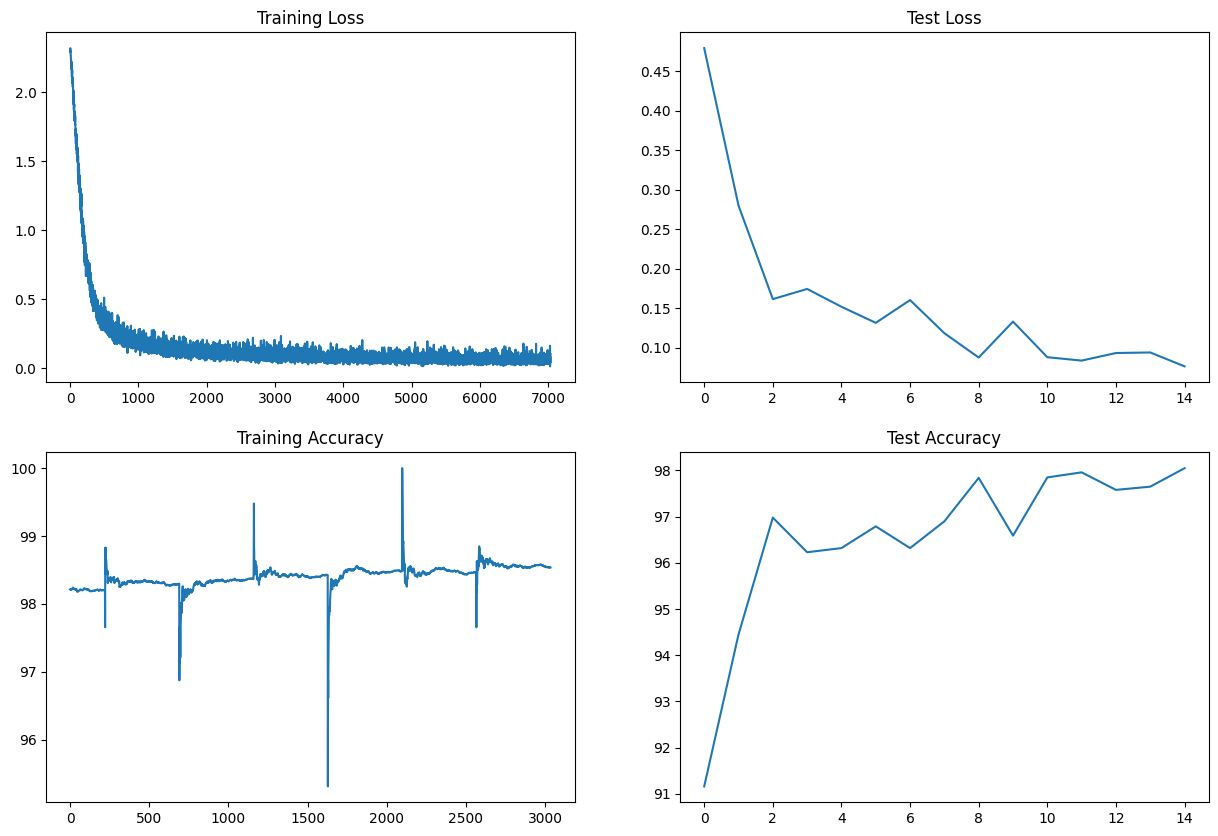

In [15]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target
Add Global Average Pooling (GAP) and remove the last BIG kernel.

## Results
- **Parameters:** 6k
- **Best Train Accuracy:** 99.54
- **Best Test Accuracy:** 98.04

## Analysis
Adding Global Average Pooling reduces accuracy - **WRONG**
We are comparing a ~6.3M model with a 6k model. Since we have reduced model capacity, a reduction in performance is expected.
